100%|██████████| 2500/2500 [01:37<00:00, 31.83it/s]


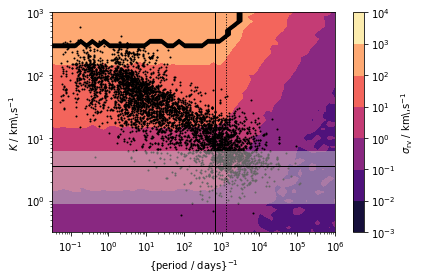

In [3]:
import sys
sys.path.insert(0, "../code/")

import numpy as np
import matplotlib.pyplot as plt
import itertools
from astropy.table import Table
from astropy import units as u
from tqdm import tqdm
from matplotlib.colors import LogNorm
from scipy import special

import utils

# (1) Simulate P, K on circular orbits.
# (2) Taking N random observations, what is the \sigma we would measure?
# (3) In each P/K bin, what fraction would we identify as binaries?

%matplotlib inline
np.random.seed(0)

DEBUG = False

sb9 = Table.read("../data/catalogs/sb9-pourbaix-et-al-orbits.fits")

K_sb9 = np.array(sb9["K1"]) # km/s
P_sb9 = np.array(sb9["Per"]) # days

keep = np.isfinite(K_sb9 * P_sb9) #* (K_sb9 > 0.5)

K_sb9, P_sb9 = (K_sb9[keep], P_sb9[keep])


# Get extents.
N_bins = 50
Ks = np.logspace(np.log10(K_sb9.min()), np.log10(K_sb9.max()), N_bins)
Ps = np.logspace(np.log10(P_sb9.min()), np.log10(P_sb9.max()), N_bins)

Ks = np.logspace(-0.5, 3, N_bins)
Ps = np.logspace(-1.5, 6, N_bins)


if DEBUG:

    # Simulate draws?
    data = np.log10(np.array([K_sb9, P_sb9]))
    Sigma = np.cov(data)
    mu = np.mean(data, axis=1)
    draws = 10**np.random.multivariate_normal(mu, Sigma, size=1000)
 
    # Sanity check plots and draws.
    fig, ax = plt.subplots()
    ax.scatter(K_sb9, P_sb9, s=1)
    ax.scatter(draws.T[0], draws.T[1], s=1, facecolor="tab:red", zorder=10)
    ax.loglog()

    for k in Ks:
        ax.axvline(k, c="#cccccc", zorder=-1)

    for p in Ps:
        ax.axhline(p, c="#cccccc", zorder=-1)

    ax.set_xlim(Ks[0], Ks[-1])
    ax.set_ylim(Ps[0], Ps[-1])


# OK, simulate each bin.
observing_span = 668 * u.day # Gaia DR2 observing span
_get_rv_nb_transits = lambda *_: np.random.randint(3, 30)
_get_intrinsic_rv_noise = lambda N, *_: 0.1 * np.ones(N)

KPs = np.array(list(itertools.product(Ks, Ps)))




N_simulations = KPs.shape[0]

N_repeats = 10

v_stds = np.zeros((N_simulations, N_repeats))


for i, (K, P) in enumerate(tqdm(KPs)):

    for j in range(N_repeats):

        # TODO: Do this per simulation.
        varphi = np.random.uniform(0, 2*np.pi)

        # Choose random times to observe.
        rv_nb_transits = _get_rv_nb_transits()
        t = np.random.uniform(0, observing_span.to(u.day).value, rv_nb_transits)

        # Initial observing point in phase.
        v_rads = K * np.sin(2 * np.pi * t / P + varphi)

        # Add intrinsic noise to each measurement.
        noise = _get_intrinsic_rv_noise(v_rads.size)
        v_rads += np.random.normal(0, 1, size=noise.size) * noise

        # Calculate standard deviation.
        v_stds[i, j] = np.std(v_rads)


        #if DEBUG:
        if False and P > 2 * 668:

            x = np.linspace(0, observing_span.to(u.day).value, 1000)
            y = K * np.sin(2 * np.pi * x / P + varphi)

            fig, ax = plt.subplots()
            ax.plot(x, y)
            ax.scatter(t, v_rads, facecolor="k")

            raise a


# TODO: Show empirical contours from SB9

# TODO: Show min (worst)/max (optimistic)/mean (expectation)/std (variance)
Z = np.mean(v_stds, axis=1).reshape((Ks.size, Ps.size))
Km, Pm = np.meshgrid(Ks, Ps)

# Max limit: 20 * np.sqrt(group["rv_nb_transits"][()] * np.pi / 2)


contourf_kwds = dict(norm=LogNorm(), cmap="magma",
                     levels=None)

#N_levels = 8
# levels = np.percentile(Z.flatten(), np.linspace(0, 100, N_levels))

fig, ax = plt.subplots()
im = ax.contourf(Ps, Ks, Z, **contourf_kwds)
ax.loglog()

cbar = plt.colorbar(im)
cbar.set_label(r"$\sigma_\mathrm{rv}$ / km\,s$^{-1}$")

ax.set_xlabel(r"{period / days}$^{-1}$")
ax.set_ylabel(r"$K$ / km\,s$^{-1}$")

fig.tight_layout()

# Show the observing span and twice that.
axvline_kwds = dict(c="#000000", zorder=10, lw=1)
ax.axvline(observing_span.to(u.day).value, linestyle="-", **axvline_kwds)
ax.axvline(2 * observing_span.to(u.day).value, linestyle=":", **axvline_kwds)


# Draw upper bound based on \stddev * np.sqrt(rv_nb_transits * np.pi / 2)
# TODO: this is approx.,...

scalar = np.sqrt(16.5 * np.pi * 2)

mean_upper_limit = 20 * scalar

foo = Z >= mean_upper_limit
ax.contour(Ps, Ks, foo, colors="k")


# Draw mean lower bound on RV jitter from GP.
# varies from 2.4 to 4.8
ax.axhline(3.6, linestyle="-", **axvline_kwds)
# TODO: Draw a more realistic band.
bands = (2.4 - 1.5, 4.8 + 1.5)
ax.axhspan(bands[0], bands[1], facecolor="#cccccc", alpha=0.5)


ax.scatter(P_sb9, K_sb9, s=1, facecolor="k")
ax.set_ylim(Ks[0], Ks[-1])
ax.set_xlim(Ps[0], Ps[-1])



import h5py as h5

results = h5.File("../results/419dd/results.hdf5", "r")
data_indices = results["indices/data_indices"][()]

sources = h5.File("../data/sources.hdf5", "r")["sources"]

rv_nb_transits_ = sources["rv_nb_transits"][()][data_indices]

w_ = results["rv/gp_predictions/theta"][()][:, 0]
mu_s_ = results["rv/gp_predictions/mu_single"][()][:, 0]
sigma_s_ = results["rv/gp_predictions/sigma_single"][()][:, 0]
mu_m_ = results["rv/gp_predictions/mu_multiple"][()][:, 0]
sigma_m_ = results["rv/gp_predictions/sigma_multiple"][()][:, 0]


S = rv_nb_transits_.size


N_bins = 50

#Ks = np.logspace(-0.22, 2.77, N_bins)
#Ps = np.logspace(-1.27, 5.06, N_bins)
#KPs = np.array(list(itertools.product(Ks, Ps)))
#KPs = np.vstack([
#    10**np.random.uniform(-0.5, 3, size=KPs.shape[0]),
#    10**np.random.uniform(-1.5, 6, size=KPs.shape[0])
#]).T


N_sims_per_bin = 100


# detection efficiency
K_diff = np.zeros((KPs.shape[0], N_sims_per_bin))
K_ests = np.zeros_like(K_diff)
K_ests_err = np.zeros_like(K_ests)
K_frac = np.zeros_like(K_diff)
detection_efficiency = np.zeros((KPs.shape[0], N_sims_per_bin))


# This is the part that takes so long...
# Numpy's random.choice is slooooooow!
#indices = np.random.choice(S, N_sims_per_bin, replace=False)
#indices = np.random.randint(0, S, N_sims_per_bin)

indices = np.random.randint(0, S, N_sims_per_bin)

for i, (K, P) in enumerate(tqdm(KPs)):

    for j, index in enumerate(indices):

        # Get data: rv_nb_transits, apparent_rp_magnitude, absolute_rp_magnitude, bp_rp

        # Choose random initial phase.
        varphi = np.random.uniform(0, 2*np.pi)

        # Calculate the RV jitter.
        # observing_span.to(u.day).value = 668
        #N = 100
        N = rv_nb_transits_[index]
        #N = np.random.randint(30, 100)
        #N = np.random.randint(5, 30)
        #N = np.random.randint(3, 15)

        #N = 10

        t = np.random.uniform(0, 668, N)
        v = K * np.sin(2 * np.pi * t / P + varphi)

        # Add intrinsic noise to each measurement.
        mu_s, sigma_s = (mu_s_[index], np.abs(sigma_s_[index]))
        
        # TODO: MAGIC HACK 0.5 is adopted intrinsic error
        #__intrinsic_error = 0
        noise = np.random.normal(mu_s, sigma_s, size=N)
        v += np.random.normal(0, 1, size=N) * noise


        #rv_jitter = np.std(v)
        v_mean = np.mean(v)
        rv_jitter = np.sqrt(np.sum((v - v_mean)**2)/(v.size - 1))


        sd_rv_jitter = rv_jitter * np.sqrt(1 - (2/(N-1)) * (special.gamma(N/2)/special.gamma((N-1)/2))**2)

        K_est = np.sqrt(2) * rv_jitter
        K_ests[i, j] = K_est
        K_ests_err[i, j] = sd_rv_jitter / np.sqrt(2)
        #K_diff[i, j] = (K_est - mu_s) - K
        K_diff[i, j] = (K_est - K)

        K_frac[i, j] = K_diff[i, j]/K

        #if K_est > 900:
        #    raise a

        # Calculate the probability this would be a detected as a binary.
        radial_velocity_error = rv_jitter / np.sqrt(rv_nb_transits_[index] * np.pi / 2)
        if radial_velocity_error >= 20:
            # Gaia team would exclude this source, so we would not detect it as a binary from RV.
            detection_efficiency[i, j] = 0

        else:
            detection_efficiency[i, j] = 1

            # Take mean likelihood value.
            w = np.clip(w_[index], 0, 1)
            mu_m, sigma_m = (mu_m_[index], np.abs(sigma_m_[index]))

            ln_s = np.log(w) + utils.normal_lpdf(rv_jitter, mu_s, sigma_s)
            ln_m = np.log(1-w) + utils.lognormal_lpdf(rv_jitter, mu_m, sigma_m)

            with np.errstate(under="ignore"):
                detection_efficiency[i, j] = 1 - np.exp(ln_s - special.logsumexp([ln_s, ln_m]))



-48.3603645568 -0.974672337788 153.31622508
[-1.9649692   0.07397692  1.16257399]


'\n(1) Now, at some P, K take N_sim examples of:\n    (a) rv_nb_transits\n    (b) initial phase\n    (c) apparent rp magnitude\n    (d) absolute rp magnitude\n    (e) bp - rp colour\n\n    and calculate the RV jitter. Then calculate the probability that we would\n    have detected it as a binary. Take the GP prediction and calculate a likelihood.\n\n    Note that if the RV jitter is more than 20 * sqrt(rv_nb_transits * np.pi/2) then the probability\n    of detecting it as a binary (from RV) is 0 because no RV would be available!\n\n(2) Plot the mean probability in each bin.\n'

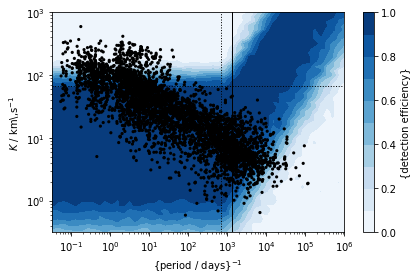

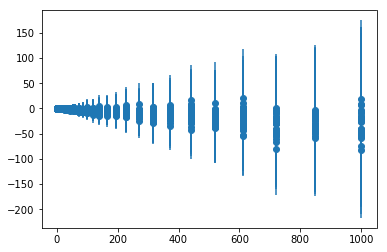

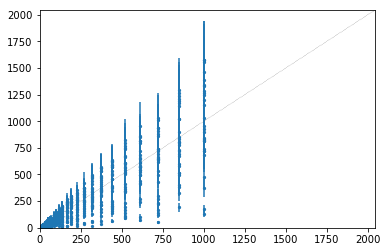

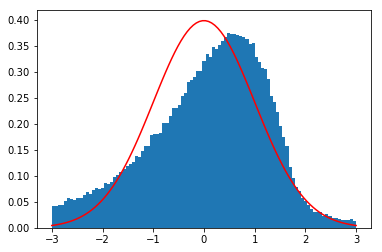

In [4]:

N_levels = 10
contourf_kwds = dict(cmap="Blues", norm=LogNorm(), levels=np.logspace(-1, 0, N_levels + 1))
contourf_kwds = dict(cmap="Blues",levels=np.linspace(0, 1, N_levels + 1))


#N_levels = 8
# levels = np.percentile(Z.flatten(), np.linspace(0, 100, N_levels))


de = np.mean(detection_efficiency, axis=1).reshape((Ks.size, Ps.size))


fig, ax = plt.subplots()
im = ax.contourf(Ps, Ks, de, **contourf_kwds)
ax.loglog()

cbar = plt.colorbar(im)
cbar.set_label(r"{detection efficiency}")

ax.set_xlabel(r"{period / days}$^{-1}$")
ax.set_ylabel(r"$K$ / km\,s$^{-1}$")

fig.tight_layout()

# Show the observing span and twice that.
axvline_kwds = dict(c="#000000", zorder=10, lw=1)
ax.axvline(observing_span.to(u.day).value, linestyle=":", **axvline_kwds)
ax.axvline(2 * observing_span.to(u.day).value, linestyle="-", **axvline_kwds)


# Show where things will start to drop off
"""
x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
y = np.ones_like(x)
lim = 668
y[x < lim] = 20 * np.sqrt(np.median(rv_nb_transits_) * np.pi/2)
y[x >= lim] += x[x >= lim]/10
ax.plot(x, y)
"""
ax.axhline(20 * np.sqrt(np.median(rv_nb_transits_) * np.pi/2), linestyle=":", **axvline_kwds)


# Show SB9
ax.scatter(P_sb9, K_sb9, s=10, facecolor="#000000", edgecolor="none", alpha=1)
ax.set_ylim(Ks[0], Ks[-1])
ax.set_xlim(Ps[0], Ps[-1])

ok = KPs.T[1] < 668



fig, ax = plt.subplots()
ax.scatter(KPs.T[0][ok], np.mean(K_diff[ok], axis=1))
ax.errorbar(KPs.T[0][ok], np.mean(K_diff[ok], axis=1), yerr=np.mean(K_ests_err[ok], axis=1), fmt="none", zorder=-1)


fig, ax = plt.subplots()
ax.scatter(KPs.T[0][ok], K_ests[ok].T[0], s=5)

ax.errorbar(KPs.T[0][ok], K_ests[ok].T[0], yerr=K_ests_err[ok].T[0], fmt="none", zorder=-1)


lims = np.array([ax.get_xlim(), ax.get_ylim()])
lims = (0.1, np.max(lims))
ax.plot(lims, lims, c="#666666", zorder=-1, linestyle=":", linewidth=0.5)
ax.set_xlim(lims)
ax.set_ylim(lims)




diff = K_diff[ok]
print(np.mean(K_diff), np.median(K_diff), np.std(K_diff))

Q = K_diff/K_ests_err

from scipy import stats

fig, ax = plt.subplots()
xi = np.linspace(-3, 3, 100)
ax.hist(Q[ok].flatten(), bins=xi, normed=True)
ax.plot(xi, stats.norm.pdf(xi, 0, 1), c="r")

print(np.percentile(Q[ok], [16, 50, 84]))

"""
dr3_baseline = 668 + 3 *365 # total guess
ax.axvline(dr3_baseline, linestyle=":", c="#666666", zorder=10, lw=0.5)
ax.axvline(2 * dr3_baseline, linestyle="-", c="#666666", zorder=10, lw=0.5)
"""


# OK, that gives intuition.

# Now let's run a realistic simulation (assuming circular orbits).
"""
(1) Now, at some P, K take N_sim examples of:
    (a) rv_nb_transits
    (b) initial phase
    (c) apparent rp magnitude
    (d) absolute rp magnitude
    (e) bp - rp colour

    and calculate the RV jitter. Then calculate the probability that we would
    have detected it as a binary. Take the GP prediction and calculate a likelihood.

    Note that if the RV jitter is more than 20 * sqrt(rv_nb_transits * np.pi/2) then the probability
    of detecting it as a binary (from RV) is 0 because no RV would be available!

(2) Plot the mean probability in each bin.
"""


# Now show the mean difference in K_est - K_true so we can see the edge effects
